In [8]:
import os
import re
import time
import glob
import json
import pickle
from pathlib import Path
from itertools import combinations
from scipy.stats import spearmanr
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tqdm import tqdm

from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, accuracy_score, precision_score, recall_score,
    classification_report, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

import xgboost as xgb
from xgboost import XGBClassifier

import optuna
from optuna.pruners import MedianPruner
from optuna.trial import TrialState

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [9]:
# ======================================================================
# 2. DIRECTORY SETUP
# ======================================================================

# Reports directories (figures & best model)
reports_figures = Path('../../../reports/modeling/figures')
reports_best_model = Path('../../../reports/modeling/best_model')

# Artifacts directory
artifacts_path = Path('../../../artifacts')

# --- Create directories only if they don't exist ---
for path in [reports_figures, reports_best_model, artifacts_path]:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created directory: {path.resolve()}")
    else:
        print(f"Directory already exists: {path.resolve()}")

# ======================================================================
# 3. DATA LOADING
# ======================================================================

# Project root and raw data directory (can be overridden by env variables)
PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', '../../')).resolve()
DATA_RAW_DIR = Path(os.environ.get('DATA_RAW_DIR', PROJECT_ROOT / 'data/raw')).resolve()

# Dataset file path
data_file = DATA_RAW_DIR / 'heart disease.parquet'

# --- Robust file loading ---
if not data_file.is_file():
    raise FileNotFoundError(f"Data file not found: {data_file.resolve()}")

# Load dataset
df = pd.read_parquet(data_file)

# Optional: drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Quick check
print(f"Dataset shape: {df.shape}")
display(df.head())

Directory already exists: P:\projects\reports\modeling\figures
Directory already exists: P:\projects\reports\modeling\best_model
Directory already exists: P:\projects\artifacts
Dataset shape: (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
# Paths
processed_data_path = Path('../../data/processed/processed_data.parquet')
artifacts_path = Path('../../artifacts')
artifacts_path.mkdir(parents=True, exist_ok=True)

# Load data
df = pd.read_parquet(processed_data_path)

# Drop prediction columns if exist
drop_cols = ['Unified_Risk_Score', 'Pred_Prob', 'Pred_Risk_Quantile']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# Explicit feature definitions based on dtypes
numerical_features = [
    'Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI',
    'Pulse_Pressure', 'Demographics_Score',
    'Clinical_Biomarkers_Score', 'Lifestyle_Score'
]

ordinal_features = ['Glucose_Level', 'Cholesterol_Level',]
ordinal_categories = [
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Glucose_Level
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Cholesterol_Level
]
for col in ordinal_features:
    df[col] = df[col].astype("category")

nominal_features = ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

# Features & target
X = df[numerical_features + ordinal_features + nominal_features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Save train/test datasets
train_df = X_train.copy()
train_df['target'] = y_train
test_df = X_test.copy()
test_df['target'] = y_test
train_df.to_parquet(artifacts_path / 'train.parquet', index=False)
test_df.to_parquet(artifacts_path / 'test.parquet', index=False)

# ColumnTransformer with proper scalers/encoders
preprocessor = ColumnTransformer(transformers=[
    ('num', RobustScaler(), numerical_features),
    ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features)
], remainder='drop')

print("Preprocessing setup complete:")
print("Numerical features:", numerical_features)
print("Ordinal features:", ordinal_features)
print("Nominal features:", nominal_features)

Preprocessing setup complete:
Numerical features: ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure', 'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
Ordinal features: ['Glucose_Level', 'Cholesterol_Level']
Nominal features: ['Sex', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']


In [11]:
# ------------------------------
# Define Optuna objective (with CV and early stopping)
# ------------------------------
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),  # Reduced upper limit
        "max_depth": trial.suggest_int("max_depth", 3, 10),            # Smaller range
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "eval_metric": "auc",
        "tree_method": "hist",
        "enable_categorical": True,
        "use_label_encoder": False,
        "random_state": 42,
        "n_jobs": -1
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced folds for speed
    aucs = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20,  # Stop if no improvement for 20 rounds
            verbose=False
        )

        preds = model.predict_proba(X_valid)[:, 1]
        aucs.append(roc_auc_score(y_valid, preds))

    return sum(aucs) / len(aucs)  # mean CV AUC

# ------------------------------
# Create Optuna study with Median Pruner (auto-stopping)
# ------------------------------
study = optuna.create_study(
    direction="maximize",
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=0)
)

# Wrap optimize with tqdm for trial progress bar
n_trials = 30  # Reduce number of trials for faster run
for _ in tqdm(range(n_trials), desc="Optuna Trials"):
    study.optimize(objective, n_trials=1, catch=(Exception,))  # Single-trial incremental optimization

# ------------------------------
# Best result
# ------------------------------
print("Best AUC (CV mean):", study.best_value)
print("Best Params:", study.best_params)

# ------------------------------
# Train final model on full dataset
# ------------------------------
final_model = XGBClassifier(
    **study.best_params,
    eval_metric="auc",
    tree_method="hist",
    enable_categorical=True,
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

final_model.fit(X, y)
print("✅ Final model trained on full dataset")

Optuna Trials: 100%|██████████| 30/30 [01:21<00:00,  2.71s/it]


Best AUC (CV mean): 0.8030712576624026
Best Params: {'n_estimators': 422, 'max_depth': 4, 'learning_rate': 0.06439748935039273, 'subsample': 0.7224788588671935, 'colsample_bytree': 0.6288331170227341}
✅ Final model trained on full dataset


Best parameters: {'n_estimators': 422, 'max_depth': 4, 'learning_rate': 0.06439748935039273, 'subsample': 0.7224788588671935, 'colsample_bytree': 0.6288331170227341}


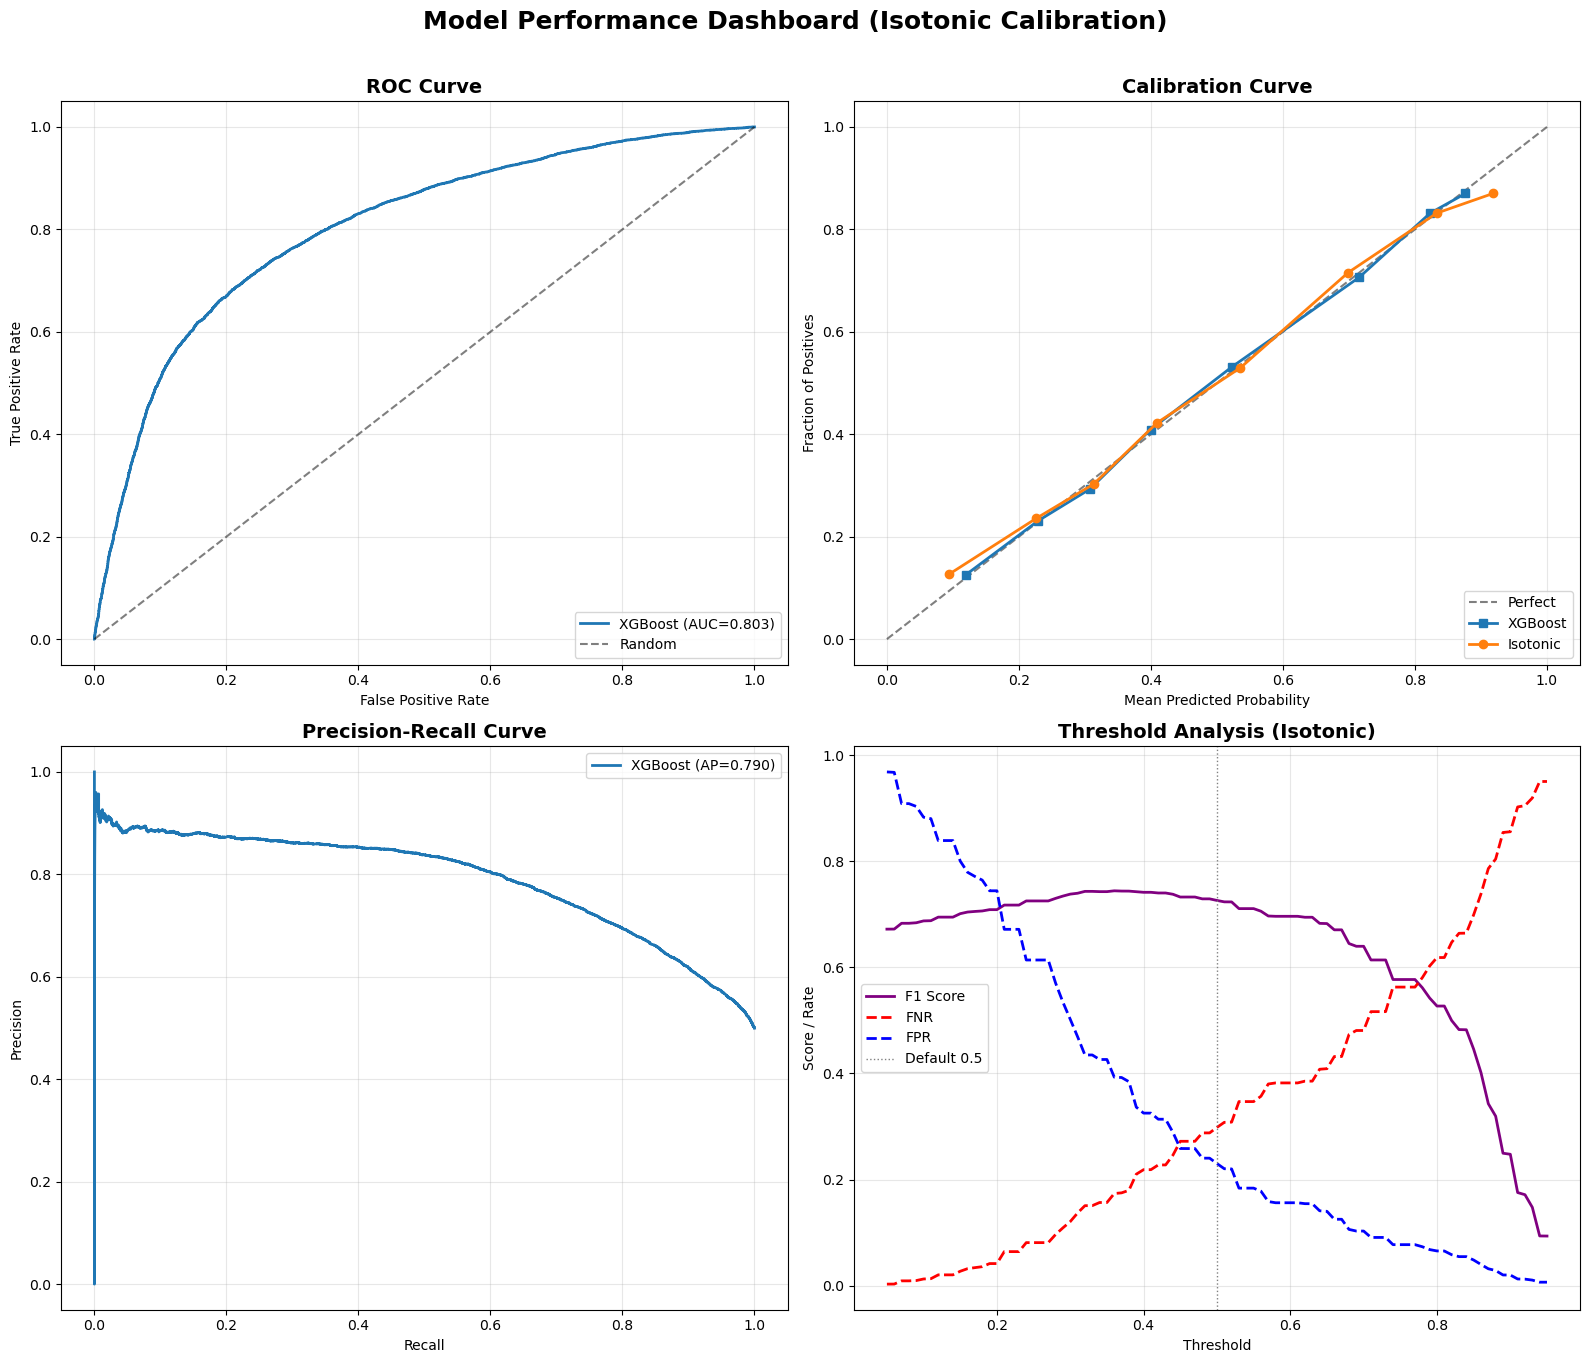

✅ Dashboard saved at: P:\projects\heart disease prediction\reports\modeling\figures\model_performance_dashboard.png


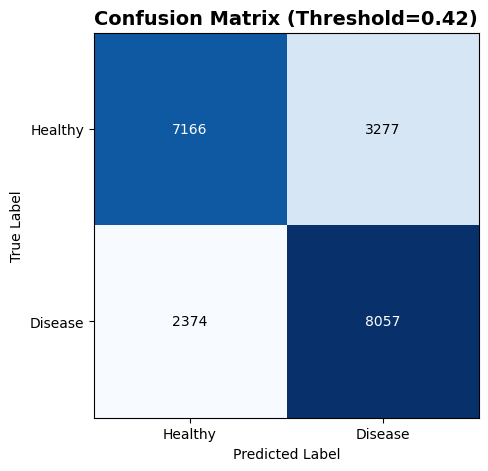

✅ Confusion matrix saved at: P:\projects\heart disease prediction\reports\modeling\figures\confusion_matrix_threshold_0.42.png

FAST PERFORMANCE RESULTS (user-selected threshold, isotonic)
Threshold: 0.425
FNR: 0.2276 | FPR: 0.3138
Accuracy: 0.7293 | F1: 0.7404
Precision: 0.7109 | Recall: 0.7724
ROC AUC: 0.8034

Confusion Matrix:
[  7166    3277]
[  2374    8057] 

Classification Report:
              precision    recall  f1-score   support

     Healthy      0.751     0.686     0.717     10443
     Disease      0.711     0.772     0.740     10431

    accuracy                          0.729     20874
   macro avg      0.731     0.729     0.729     20874
weighted avg      0.731     0.729     0.729     20874




In [12]:
# ================================================
# COMPLETE MODEL PERFORMANCE DASHBOARD (4 SUBPLOTS) + CONFUSION MATRIX
# ================================================

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, confusion_matrix, accuracy_score, precision_score, recall_score,
    classification_report
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

# -------------------------------
# Reports folder (outside src)
# -------------------------------
REPORTS_DIR = Path('../../reports/modeling/figures')
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Get best parameters from Optuna study
# -------------------------------
best_params = study.best_params
print(f"Best parameters: {best_params}")

# -------------------------------
# Fit model
# -------------------------------
try:
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1))
    ])
except NameError:
    pipeline = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)

pipeline.fit(X_train, y_train)
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

# -------------------------------
# Isotonic calibration
# -------------------------------
calibrator = CalibratedClassifierCV(pipeline, cv='prefit', method='isotonic')
calibrator.fit(X_train, y_train)
y_pred_iso = calibrator.predict_proba(X_test)[:,1]

# -------------------------------
# Dashboard figure (4 subplots)
# -------------------------------
fig, axes = plt.subplots(2,2, figsize=(16,14))
axes = axes.ravel()

# --- 1) ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'XGBoost (AUC={roc_auc:.3f})', linewidth=2)
axes[0].plot([0,1],[0,1],'k--', alpha=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right'); axes[0].grid(alpha=0.3)

# --- 2) Calibration Curve ---
frac_orig, mean_orig = calibration_curve(y_test, y_pred_proba, n_bins=8, strategy='quantile')
frac_iso, mean_iso = calibration_curve(y_test, y_pred_iso, n_bins=8, strategy='quantile')
axes[1].plot([0,1],[0,1],'k--', alpha=0.5, label='Perfect')
axes[1].plot(mean_orig, frac_orig, 's-', linewidth=2, label='XGBoost')
axes[1].plot(mean_iso, frac_iso, 'o-', linewidth=2, label='Isotonic')
axes[1].set_xlabel('Mean Predicted Probability'); axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right'); axes[1].grid(alpha=0.3)

# --- 3) Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
axes[2].plot(recall, precision, linewidth=2, label=f'XGBoost (AP={avg_precision:.3f})')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper right'); axes[2].grid(alpha=0.3)

# --- 4) Threshold Analysis F1/FNR/FPR ---
thresholds = np.linspace(0.05,0.95,91)
f1_scores, fnrs, fprs = [],[],[]
for t in thresholds:
    y_pred_t = (y_pred_iso >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    fnrs.append(fn/(fn+tp) if (fn+tp)>0 else 1.0)
    fprs.append(fp/(fp+tn) if (fp+tn)>0 else 1.0)
    f1_scores.append(f1_score(y_test, y_pred_t, zero_division=0))

axes[3].plot(thresholds, f1_scores, color='purple', linewidth=2, label='F1 Score')
axes[3].plot(thresholds, fnrs, color='red', linestyle='--', linewidth=2, label='FNR')
axes[3].plot(thresholds, fprs, color='blue', linestyle='--', linewidth=2, label='FPR')
axes[3].axvline(0.5, color='gray', linestyle=':', linewidth=1, label='Default 0.5')
axes[3].set_xlabel('Threshold'); axes[3].set_ylabel('Score / Rate')
axes[3].set_title('Threshold Analysis (Isotonic)', fontsize=14, fontweight='bold')
axes[3].legend(); axes[3].grid(alpha=0.3)

plt.suptitle('Model Performance Dashboard (Isotonic Calibration)', fontsize=18, fontweight='bold', y=0.97)
plt.tight_layout(rect=[0,0,1,0.96])

# --- Save dashboard ---
dashboard_path = REPORTS_DIR / 'model_performance_dashboard.png'
plt.savefig(dashboard_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✅ Dashboard saved at: {dashboard_path.resolve()}")

# --- Interactive Confusion Matrix ---
while True:
    try:
        user_threshold = float(input("Enter threshold (0.05-0.95) for Confusion Matrix: "))
        if 0.05<=user_threshold<=0.95: break
        else: print("Threshold must be between 0.05-0.95")
    except ValueError:
        print("Invalid input. Please enter a number.")

y_pred_user = (y_pred_iso >= user_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_user)

cm_path = REPORTS_DIR / f'confusion_matrix_threshold_{user_threshold:.2f}.png'
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix (Threshold={user_threshold:.2f})', fontsize=14, fontweight='bold')
th = cm.max()/2
for i,j in np.ndindex(cm.shape):
    plt.text(j,i,format(cm[i,j],'d'), ha='center', va='center',
             color='white' if cm[i,j]>th else 'black')
plt.xticks([0,1], ['Healthy','Disease']); plt.yticks([0,1], ['Healthy','Disease'])
plt.xlabel('Predicted Label'); plt.ylabel('True Label')
plt.savefig(cm_path, dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print(f"✅ Confusion matrix saved at: {cm_path.resolve()}")

# --- Print metrics ---
accuracy = accuracy_score(y_test, y_pred_user)
precision = precision_score(y_test, y_pred_user, zero_division=0)
recall = recall_score(y_test, y_pred_user, zero_division=0)
f1 = f1_score(y_test, y_pred_user, zero_division=0)
tn, fp, fn, tp = cm.ravel()
print(f"""
FAST PERFORMANCE RESULTS (user-selected threshold, isotonic)
Threshold: {user_threshold:.3f}
FNR: {fn/(fn+tp):.4f} | FPR: {fp/(fp+tn):.4f}
Accuracy: {accuracy:.4f} | F1: {f1:.4f}
Precision: {precision:.4f} | Recall: {recall:.4f}
ROC AUC: {roc_auc:.4f}

Confusion Matrix:
[{tn:6d}  {fp:6d}]
[{fn:6d}  {tp:6d}] 

Classification Report:
{classification_report(y_test, y_pred_user, target_names=['Healthy','Disease'], digits=3)}
""")

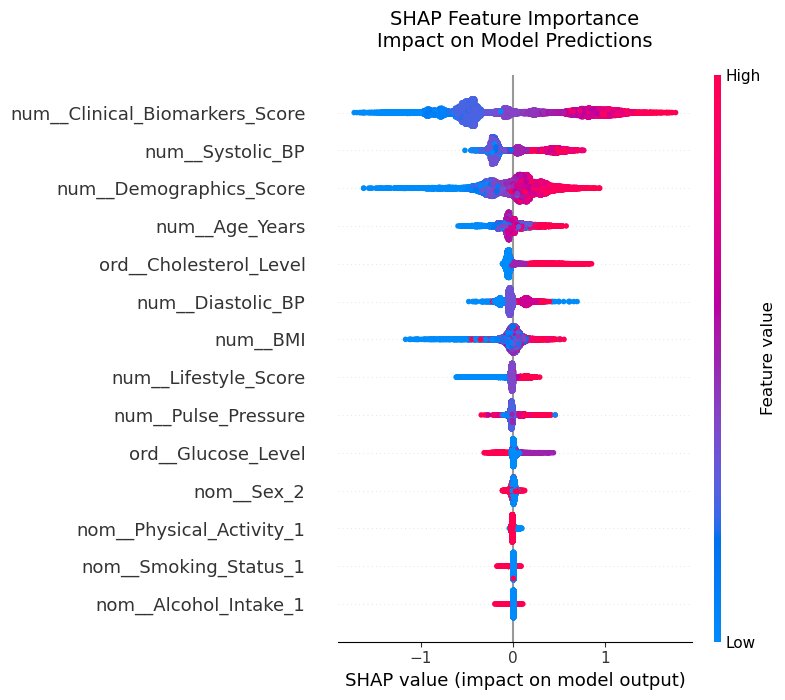


=== Top 10 Most Important Features ===
num__Clinical_Biomarkers_Score: 0.6290
num__Systolic_BP: 0.2548
num__Demographics_Score: 0.2316
num__Age_Years: 0.1067
ord__Cholesterol_Level: 0.0869
num__Diastolic_BP: 0.0867
num__BMI: 0.0710
num__Lifestyle_Score: 0.0490
num__Pulse_Pressure: 0.0363
ord__Glucose_Level: 0.0255

✅ SHAP plot saved at: P:\projects\heart disease prediction\reports\modeling\figures\shap_summary_plot.png


In [13]:
# ============================================================================== 
# SHAP SUMMARY SWARM PLOT
# ============================================================================== 
# Set up reports directory
reports_dir = Path('../../reports/modeling/figures')
reports_dir.mkdir(parents=True, exist_ok=True)

try:
    # --------------------------- Prepare Data ---------------------------
    # Preprocessed test data
    X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

    # Get feature names
    if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
        feature_names = list(pipeline.named_steps['preprocessor'].get_feature_names_out())
    else:
        # Fallback: combine numerical, ordinal, and one-hot encoded nominal features
        feature_names = (
            numerical_features + 
            ordinal_features + 
            [f"{col}_{val}" for col in nominal_features for val in X[col].unique()[1:]]
        )

    X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

    # --------------------------- SHAP Explainer ---------------------------
    xgb_model = pipeline.named_steps['classifier']
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test_processed)

    # Binary classification: use positive class
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values = shap_values[1]

    # --------------------------- Plot SHAP Summary ---------------------------
    plt.figure(figsize=(15, 10))
    shap.summary_plot(
        shap_values, 
        X_test_df,
        plot_type="dot",
        show=False,
        max_display=20
    )
    plt.title("SHAP Feature Importance\nImpact on Model Predictions", fontsize=14, pad=20)
    
    # Save plot
    save_path = reports_dir / 'shap_summary_plot.png'
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # --------------------------- Top Feature Importance ---------------------------
    importance_dict = dict(zip(feature_names, np.abs(shap_values).mean(axis=0)))
    top_features = dict(sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10])

    print("\n=== Top 10 Most Important Features ===")
    for feat, imp in top_features.items():
        print(f"{feat}: {imp:.4f}")

    print(f"\n✅ SHAP plot saved at: {save_path.resolve()}")

except Exception as e:
    print(f"[ERROR] Generating SHAP plot: {str(e)}")
    raise

Top 6 features by SHAP importance: ['Clinical Biomarkers Score', 'Systolic Bp', 'Demographics Score', 'Age Years', 'Cholesterol Level', 'Diastolic Bp']
✅ Feature interaction plots saved at: P:\projects\heart disease prediction\reports\modeling\figures\feature_interaction_plots.png


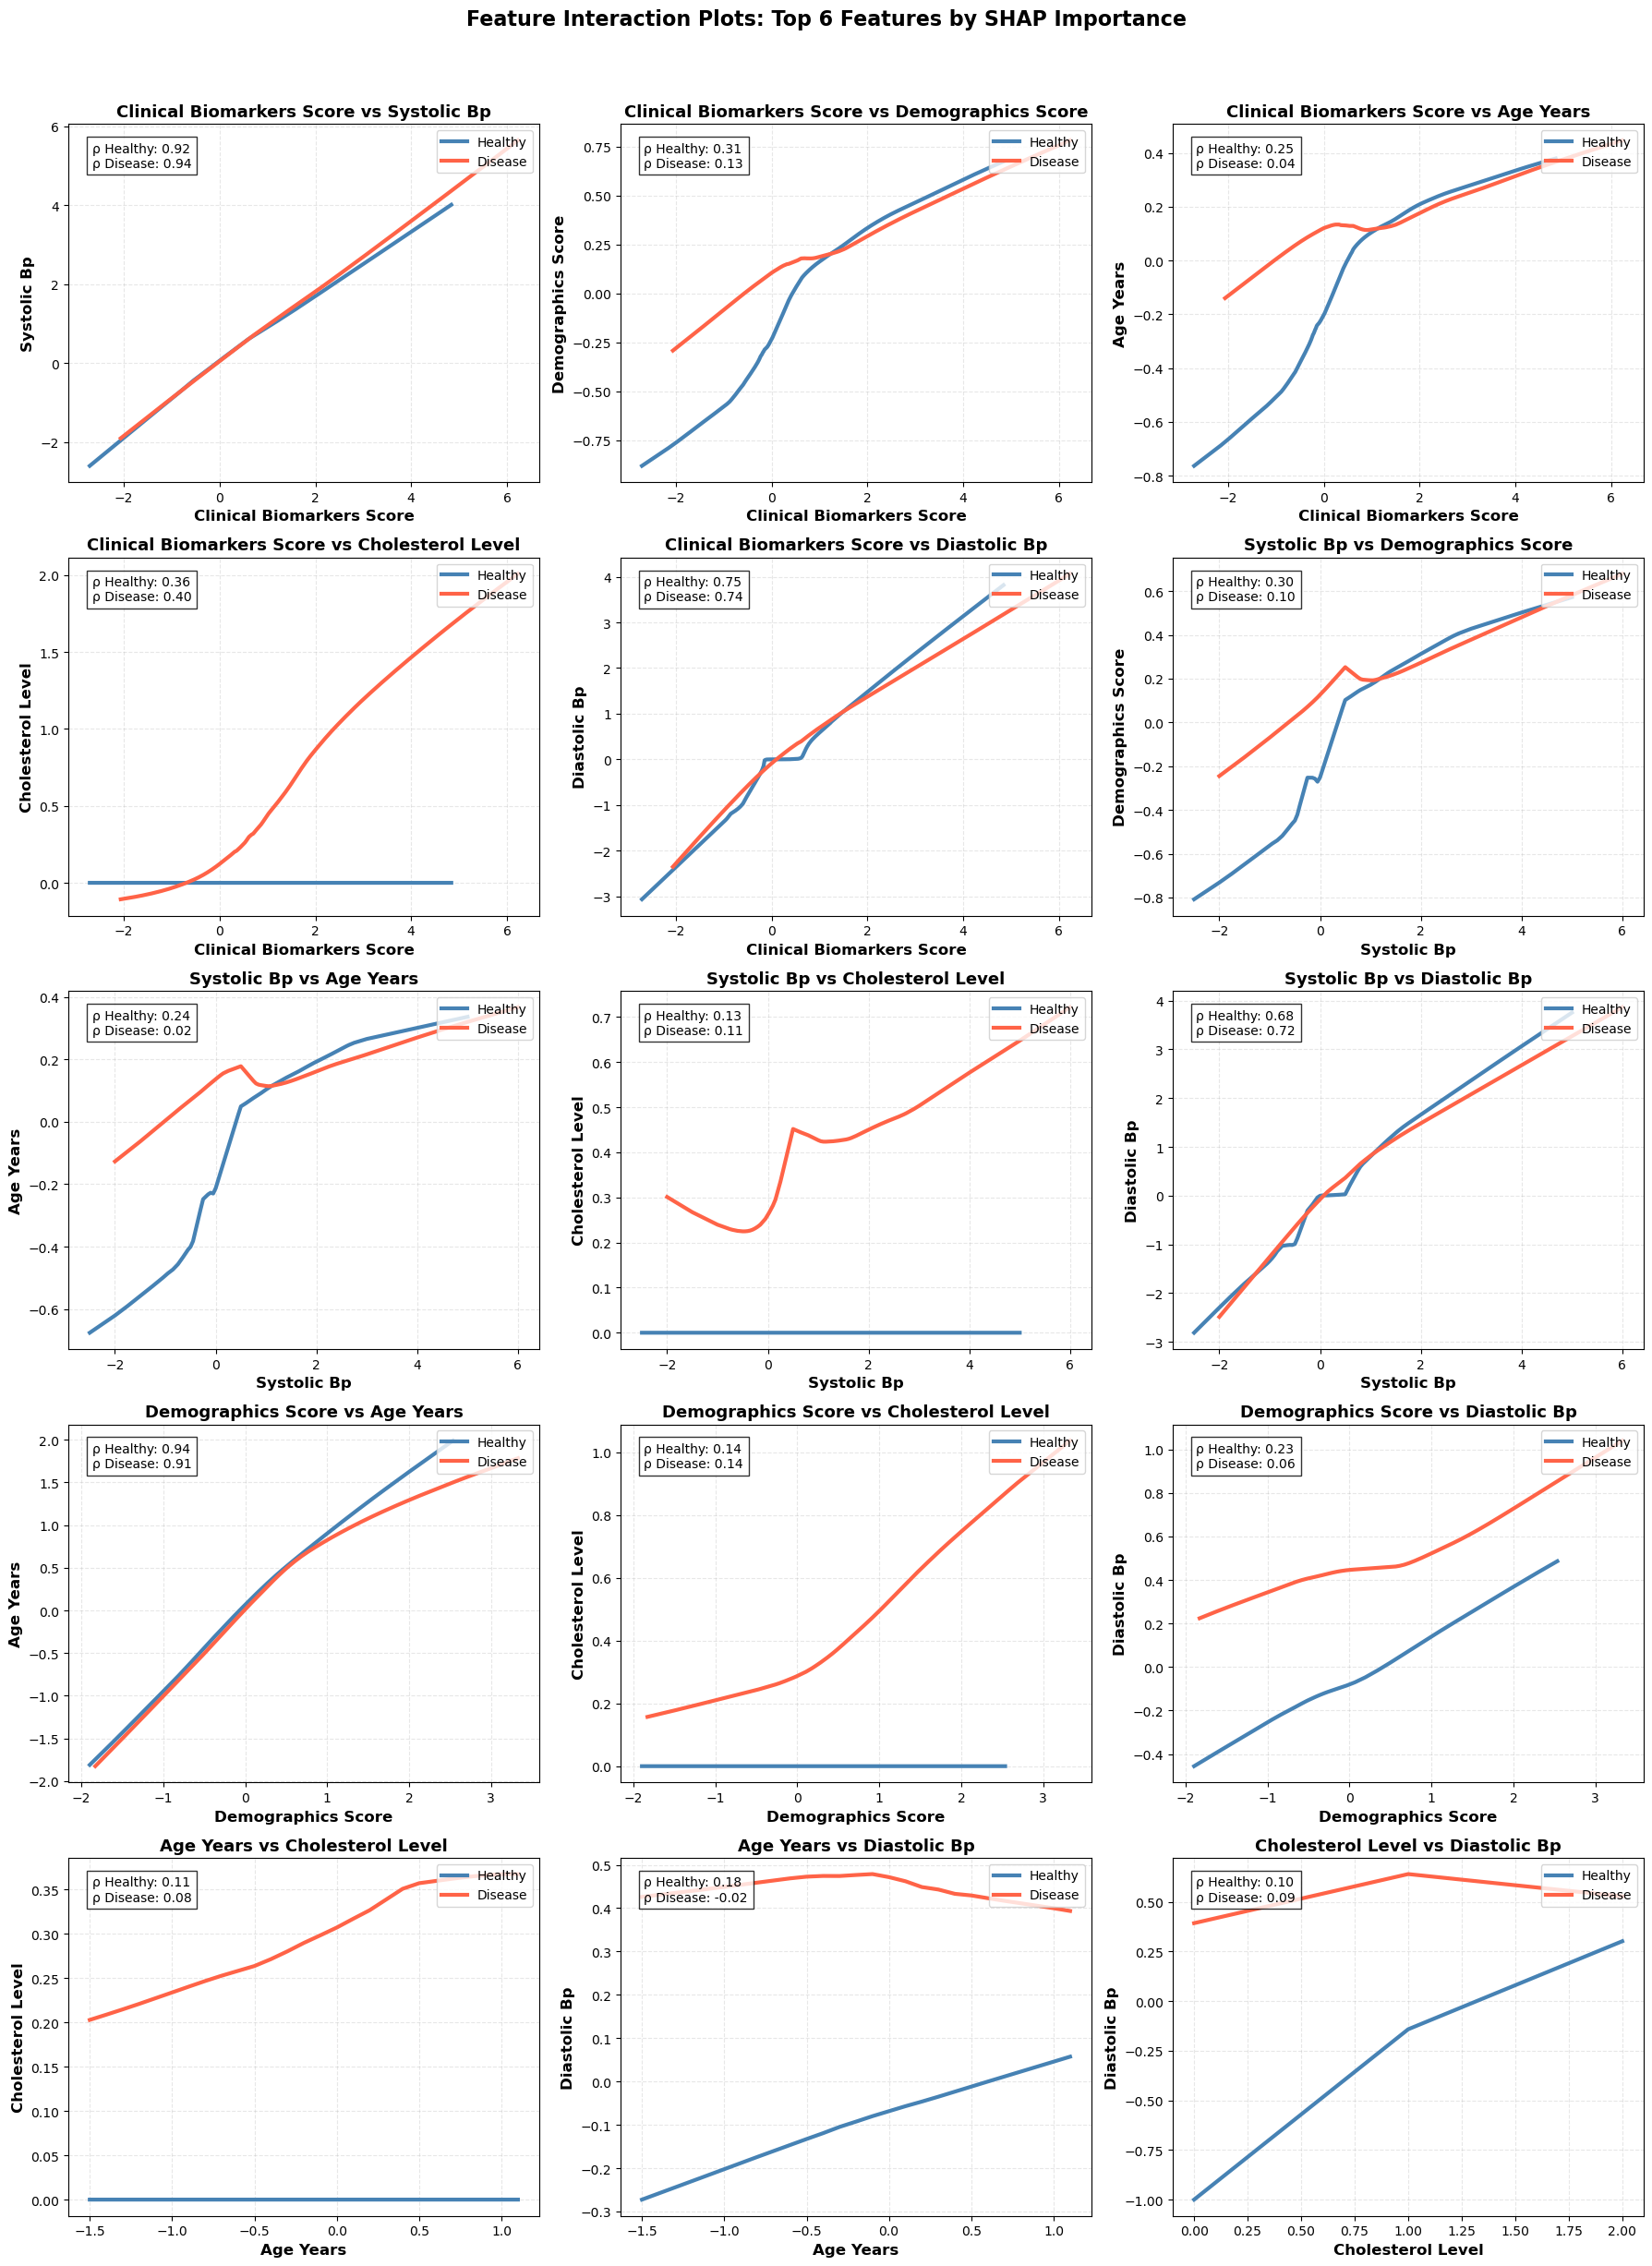


FEATURE INTERACTION CORRELATION SUMMARY TABLE
                Feature 1          Feature 2 Overall ρ Overall Strength Overall Direction Healthy ρ Disease ρ Correlation Difference
Clinical Biomarkers Score        Systolic Bp     0.946      Very Strong          Positive     0.924     0.940                  0.016
       Demographics Score          Age Years     0.932      Very Strong          Positive     0.945     0.906                 -0.038
Clinical Biomarkers Score       Diastolic Bp     0.777      Very Strong          Positive     0.745     0.736                 -0.010
              Systolic Bp       Diastolic Bp     0.748      Very Strong          Positive     0.683     0.719                  0.036
Clinical Biomarkers Score  Cholesterol Level     0.437         Moderate          Positive     0.363     0.399                  0.037
Clinical Biomarkers Score Demographics Score     0.319         Moderate          Positive     0.306     0.131                 -0.175
              Systolic

In [14]:
# ================================================
# FEATURE INTERACTION PLOTS & CORRELATION SUMMARY
# ================================================

# -------------------------------
# Reports folder (outside src)
# -------------------------------
reports_dir = Path('../../reports/modeling/figures')
reports_dir.mkdir(parents=True, exist_ok=True)  # create if missing

# File path for saving
interaction_plot_path = reports_dir / 'feature_interaction_plots.png'

# -------------------------------
# 1. Compute SHAP values
# -------------------------------
X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values_test = explainer.shap_values(X_test_processed)

# Feature importance
feat_imp = np.abs(shap_values_test).mean(axis=0)
sorted_idx = np.argsort(-feat_imp)
feature_names_all = pipeline.named_steps['preprocessor'].get_feature_names_out()

# -------------------------------
# 2. Select top K features
# -------------------------------
K = 6
topK_idx = sorted_idx[:K]
topK_names = [feature_names_all[i].split('__')[-1].replace('_', ' ').title() for i in topK_idx]
print(f"Top {K} features by SHAP importance: {topK_names}")

# -------------------------------
# 3. Generate all unique pairs
# -------------------------------
pairs = list(combinations(topK_idx, 2))

# -------------------------------
# 4. Helper function for plotting
# -------------------------------
def plot_feature_interaction(idx1, idx2, ax, linewidth=3):
    x = X_test_processed[:, idx1]
    y = X_test_processed[:, idx2]
    
    name1 = feature_names_all[idx1].split('__')[-1].replace('_', ' ').title()
    name2 = feature_names_all[idx2].split('__')[-1].replace('_', ' ').title()
    
    mask_healthy = (y_test == 0)
    mask_disease = (y_test == 1)
    
    # LOWESS trend lines
    sns.regplot(x=x[mask_healthy], y=y[mask_healthy], scatter=False, lowess=True, ax=ax,
                color='steelblue', line_kws={'linewidth': linewidth}, label='Healthy')
    sns.regplot(x=x[mask_disease], y=y[mask_disease], scatter=False, lowess=True, ax=ax,
                color='tomato', line_kws={'linewidth': linewidth}, label='Disease')
    
    # Spearman correlation
    rho_healthy, _ = spearmanr(x[mask_healthy], y[mask_healthy]) if mask_healthy.sum() > 1 else (np.nan, np.nan)
    rho_disease, _ = spearmanr(x[mask_disease], y[mask_disease]) if mask_disease.sum() > 1 else (np.nan, np.nan)
    
    ax.text(0.05, 0.95, f"ρ Healthy: {rho_healthy:.2f}\nρ Disease: {rho_disease:.2f}",
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.8))
    
    ax.set_xlabel(name1, fontsize=12, fontweight='bold')
    ax.set_ylabel(name2, fontsize=12, fontweight='bold')
    ax.set_title(f'{name1} vs {name2}', fontsize=13, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)

# -------------------------------
# 5. Plot all pairs in a grid
# -------------------------------
n_pairs = len(pairs)
n_cols = 3
n_rows = int(np.ceil(n_pairs / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*5))
axes = axes.ravel() if n_rows > 1 else [axes]

for ax, (idx1, idx2) in zip(axes, pairs):
    plot_feature_interaction(idx1, idx2, ax)

# Remove empty subplots
for ax in axes[n_pairs:]:
    fig.delaxes(ax)

plt.suptitle(f'Feature Interaction Plots: Top {K} Features by SHAP Importance',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save figure (overwrite if already present)
plt.savefig(interaction_plot_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"✅ Feature interaction plots saved at: {interaction_plot_path.resolve()}")
plt.show()

# -------------------------------
# 6. Create comprehensive correlation summary table
# -------------------------------
summary_data = []

for idx1, idx2 in pairs:
    feature1 = feature_names_all[idx1].split('__')[-1].replace('_', ' ').title()
    feature2 = feature_names_all[idx2].split('__')[-1].replace('_', ' ').title()
    
    x = X_test_processed[:, idx1]
    y = X_test_processed[:, idx2]
    
    mask_healthy = (y_test == 0)
    mask_disease = (y_test == 1)
    
    rho_overall, _ = spearmanr(x, y)
    rho_healthy, _ = spearmanr(x[mask_healthy], y[mask_healthy]) if mask_healthy.sum() > 1 else (np.nan, np.nan)
    rho_disease, _ = spearmanr(x[mask_disease], y[mask_disease]) if mask_disease.sum() > 1 else (np.nan, np.nan)
    
    def get_strength(rho):
        if abs(rho) >= 0.7: return "Very Strong"
        elif abs(rho) >= 0.5: return "Strong"
        elif abs(rho) >= 0.3: return "Moderate"
        elif abs(rho) >= 0.1: return "Weak"
        else: return "Very Weak"
    
    def get_direction(rho):
        if rho > 0: return "Positive"
        elif rho < 0: return "Negative"
        else: return "None"
    
    summary_data.append({
        'Feature 1': feature1,
        'Feature 2': feature2,
        'Overall ρ': f"{rho_overall:.3f}",
        'Overall Strength': get_strength(rho_overall),
        'Overall Direction': get_direction(rho_overall),
        'Healthy ρ': f"{rho_healthy:.3f}" if not np.isnan(rho_healthy) else "N/A",
        'Disease ρ': f"{rho_disease:.3f}" if not np.isnan(rho_disease) else "N/A",
        'Correlation Difference': f"{(rho_disease - rho_healthy):.3f}" 
                                  if not (np.isnan(rho_disease) or np.isnan(rho_healthy)) else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
summary_df['Abs_ρ'] = summary_df['Overall ρ'].replace('N/A','0').astype(float).abs()
summary_df = summary_df.sort_values('Abs_ρ', ascending=False).drop('Abs_ρ', axis=1)

print("\n" + "="*80)
print("FEATURE INTERACTION CORRELATION SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False, max_colwidth=25))